In [ ]:
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install opencv-contrib-python==3.4.2.17
!pip install pandas
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install scikit-optimize
!pip install shortuuid
!pip install torch
!pip install torchsummary
!pip install torchvision


In [1]:
import copy
import csv
import cv2
import glob
import os
import re
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torchvision import models, transforms

torch.manual_seed(0)
np.random.seed(0)

def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C2"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"
TEST_PATCHES_DATA_DIR = "data/test/patches"


## Enable GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Split data
Generate random, stratified 80/20 split for training and validation sets

In [3]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [4]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 3
PATCH_COLUMNS = 3


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [5]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [6]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data/train/patches exists. Skipping.
data/val/patches exists. Skipping.
data/test/patches exists. Skipping.
data/train-all/patches exists. Skipping.
Done.


## Datasets

Given a directory of images and a CSV file of annotations, this defines a PyTorch Dataset which will load an image from disk and apply all configure transformations and return a tuple containing the image and label.


In [7]:
class SoybeanDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, ann_df, whole_image_ann_df, transforms=None):
        """
        Args:
            data_path (string): path to images
            ann_df (string): pandas data frame containing file names and annotations
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        
        self.data = ann_df
        self.whole_image_data = whole_image_ann_df
        self.labels = np.asarray(self.data.iloc[:, 1])
        
        self.transforms = transforms

    def __getitem__(self, index):
        #print('index:', index)
        image_label = int(self.labels[index])
        file_name = self.data.file_name[index]
        img_path = os.path.join(self.data_path, file_name)

        img = Image.open(img_path)
        
        # Transform image
        if self.transforms is not None:
            img = self.transforms(img)

        return file_name, img, image_label

    def __len__(self):
        return self.data.shape[0]


class SoybeanTestDatasetFolder(torch.utils.data.IterableDataset):
    def __init__(self, data_path, transforms=None):
        """
        Args:
            data_path (string): path to images
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        self.transforms = transforms
        
        self.images = []
        
        for root, _, fnames in sorted(os.walk(data_path, followlinks=True)):
            for fname in sorted(fnames):
                path = fname
                if is_image_file(path):
                    self.images.append(path)

                                       
    def image_gen(self):
        for i in self.images:
            img_path = os.path.join(self.data_path, i)
            img = Image.open(img_path)
        
            # Transform image
            if self.transforms is not None:
                img = self.transforms(img)
                
            yield img
            

    def __iter__(self):
        return iter(self.image_gen())

    
    def __len__(self):
        return len(self.images)
    


class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_dataloader,
                 val_dataloader=None,
                 test_dataloader=None):
        self.class_weights = class_weights
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader


def compute_class_weights(df, y_col):
    """
    Returns a list of class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy(dtype=np.int32).flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return torch.tensor(weights, dtype=torch.float32).to(device)
    


### Common image transformations
These images transformations will apply to both train and validation data.

In [8]:
class SamplewiseCenterNormalize(object):

    def __init__(self):
        pass
    
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        
        return torch.div(torch.add(tensor, torch.mul(torch.mean(tensor), -1)), torch.std(tensor) + 1e-6)
        

    def __repr__(self):
        return self.__class__.__name__



DATA_TRANSFORMS = transforms.Compose([
    
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    
    
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=10, scale=(1.0, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.RandomCrop(size=(480,640)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()

    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

TEST_DATA_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Train 0.80/Val 0.20 Split

In [9]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_dataset = SoybeanDataset(TRAIN_SPLIT_PATCHES_DATA_DIR, train_ann_df, train_whole_image_ann_df, transforms=DATA_TRANSFORMS)
    val_dataset = SoybeanDataset(VAL_SPLIT_PATCHES_DATA_DIR, val_ann_df, val_whole_image_ann_df, transforms=TEST_DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_PATCHES_DATA_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=BATCH_SIZE,
                                                 pin_memory=True,
                                                 num_workers=16)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, val_dataloader, test_dataloader)


### Train 100%

Train with all the data in the `TrainData-C2` dataset 

In [10]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)

    train_dataset = SoybeanDataset(TRAIN_DATA_PATCHES_DIR, ann_df, train_whole_image_ann_df, transforms=DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_PATCHES_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, None, test_dataloader)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [11]:
def get_model(n1, n2, dropout, batch_normalization=False):
    if batch_normalization:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16(pretrained=True) 

    # Freeze training for all layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d((1,1))
    
    # Replace the VGG16 classifier with a custom classifier for soybean wilting 
    model.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, n1, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n1, n2, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n2, 5, bias=True)
    )
    
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [12]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs):
    """
    Trains the specified neural network model
    
    Args:
        model:         - neural network model to train
        criterion:     - loss function
        optimizer:     - gradient descent optimization algorithm
        dataloaders:   - dict of DataLoaders for training and validation data
        num_epochs:    - number of epochs to train model
    Returns:
        model   - trained model with weights from the epoch with the best validation accuracy
        history - dict of training and validation loss and accuracy for all epochs
    """
    since = time.time()
    
    # summary(model, input_size=(3, 224, 224))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train': {'loss': [], 'acc': []}}
    phases = ['train']
    if ('val' in dataloaders and dataloaders['val'] is not None):
        phases += ['val']
        history['val'] = {'loss': [], 'acc': []}
    
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and optionally, a validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            phase_start = time.time()

            sample_count = 0
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, inputs, labels in dataloaders[phase]:               
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        nn.utils.clip_grad_value_(model.parameters(), 0.5)
                        optimizer.step()

                # statistics
                sample_count += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.data.view_as(preds)).cpu().sum()
            
            print('Num samples', sample_count)
            
            epoch_loss = running_loss / sample_count
            epoch_acc = running_corrects.double() / sample_count
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
            phase_end = time.time()
            phase_elapsed = phase_end - phase_start

            print('{} {} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, str(timedelta(seconds=phase_elapsed)), epoch_loss, epoch_acc))

            # deep copy the model
            if ('val' not in phases or phase == 'val') and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print('Elapsed time: {}'.format(str(timedelta(seconds=epoch_elapsed))))
        
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Train models

In [13]:
BATCH_SIZE = 32

def get_sample_count(dataset, sampler):
    if (sampler is not None):
        return len(sampler)
    elif (dataset is not None):
        return len(dataset)
    else:
        return None
    

def train(run_id, model, group, num_epochs):
    criterion = nn.CrossEntropyLoss(weight=group.class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
    
    dataloaders = {
        'train': group.train_dataloader,
        'val': group.val_dataloader
    }
 
    model_trained, history = train_model(model, criterion, optimizer, dataloaders, num_epochs)
    
    
    return model_trained, history


def get_all_labels(loader):
    all_labels = torch.tensor([], dtype=torch.long)
    for batch in loader:
        _, _, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_labels


def get_all_whole_image_filenames(loader):
    return loader.dataset.whole_image_data['file_name'].to_numpy()
    

def get_all_whole_image_labels(loader):
    return loader.dataset.whole_image_data['annotation'].to_numpy(dtype=int)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, train_dataloader, val_dataloader=None):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Create count of the number of epochs
    epoch_count = range(1, len(history['train']['loss']) + 1)

    # Visualize loss history
    plt.plot(epoch_count, history['train']['loss'], 'g-')
    loss_legend = ['Training Loss']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['loss'], 'b-')
        loss_legend += ['Validation Loss']
        
    plt.legend(loss_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Visualize accuracy history
    plt.plot(epoch_count, history['train']['acc'], 'g-')
    acc_legend = ['Training Accuracy']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['acc'], 'b-')
        acc_legend += ['Validation Accuracy']
    
    plt.legend(acc_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Training confusion matrix
    train_patch_labels = get_all_labels(train_dataloader).cpu().numpy()
    train_patch_predictions = predict(model, train_dataloader).cpu().numpy()
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    # Generate prediction label results file
    write_patch_predictions(run_id, 'train', output_dir, train_dataloader, train_patch_predictions)
    
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    train_whole_image_filenames = get_all_whole_image_filenames(train_dataloader)
    train_whole_image_labels = get_all_whole_image_labels(train_dataloader)
    train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
    print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
    write_whole_image_predictions(run_id, 'train', output_dir, 
                                  train_whole_image_filenames, 
                                  train_whole_image_labels, 
                                  train_whole_image_predictions)
    
    # Validation confusion matrix
    if val_dataloader is not None:
        val_patch_labels = get_all_labels(val_dataloader).cpu().numpy()
        val_patch_predictions = predict(model, val_dataloader).cpu().numpy()
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
        
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        val_whole_image_filenames = get_all_whole_image_filenames(val_dataloader)
        val_whole_image_labels = get_all_whole_image_labels(val_dataloader)
        val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
        print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
        # Generate prediction label results file
        write_patch_predictions(run_id, 'val', output_dir, val_dataloader, val_patch_predictions)
        
        write_whole_image_predictions(run_id, 'val', output_dir, 
                                  val_whole_image_filenames, 
                                  val_whole_image_labels, 
                                  val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    torch.save(model_trained, os.path.join(output_dir, "{}_weights.pt".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group.train_dataloader, group.val_dataloader)
    
    # Classify test data
    return predict(model_trained, group.test_dataloader)


def predict(model, dataloader):
    predictions = torch.tensor([], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for data in dataloader:
            if (type(data) is list):
                images = data[1].to(device)
            else:
                images = data.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions = torch.cat((predictions, predicted))

    return predictions


def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions.cpu().numpy()
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    confusion_matrix = np.zeros((5, 5))
    labels = [0, 1, 2, 3, 4]
    for i in range(len(labels)):
        for j in range(len(labels)):
            ground_truth = y==labels[i]
            prediction = y_hat==labels[j]
            confusion_matrix[i, j] = sum(np.bitwise_and(ground_truth, prediction))
    df = pd.DataFrame(confusion_matrix, dtype=int)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, dataloader, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for file_names, _, labels in dataloader:
        for j in range(BATCH_SIZE):
            if len(file_names) > j:
                df = df.append({'file_name': file_names[j], 
                                'annotation': labels[j].item(), 
                                'prediction': patch_predictions[i]}, ignore_index=True)
                i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    print('filenames:', len(filenames))
    print('labels:', len(labels))
    print('predictions:', len(predictions))
    
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [14]:
def run_trial(name, model, class_weights=None, num_epochs=40):
    run_id = shortuuid.uuid()
    
    # output directory
    output_dir = os.path.join("output", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, train_val_split_group(class_weights), num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output/3MHrnTLxRRTuxvC96zCwqv
Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:33.240612 loss: 1.0805 accuracy: 0.5373
Num samples 2295
val 0:00:04.655673 loss: 5.3817 accuracy: 0.4017
Elapsed time: 0:00:37.899403

Epoch 1/39
----------
Num samples 18000
train 0:00:33.374090 loss: 1.0362 accuracy: 0.5922
Num samples 2295
val 0:00:04.691853 loss: 6.4058 accuracy: 0.4022
Elapsed time: 0:00:38.069121

Epoch 2/39
----------
Num samples 18000
train 0:00:33.429931 loss: 1.0161 accuracy: 0.6173
Num samples 2295
val 0:00:04.717148 loss: 6.7727 accuracy: 0.4044
Elapsed time: 0:00:38.150485

Epoch 3/39
----------
Num samples 18000
train 0:00:33.449717 loss: 0.9958 accuracy: 0.6312
Num samples 2295
val 0:00:04.666818 loss: 5.3407 accuracy: 0.4057
Elapsed time: 0:00:38.119810

Epoch 4/39
----------
Num samples 18000
train 0:00:33.603386 loss: 0.9266 accuracy: 0.6481
Num samples 22

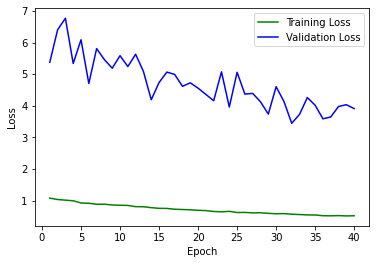

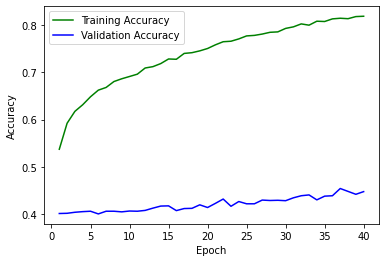

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,282,3312,2,1,3
1,0,3592,0,0,8
2,1,2736,580,109,174
3,0,1133,83,1042,1342
4,0,15,0,7,3578


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,16,384,0,0,0
1,0,400,0,0,0
2,0,348,34,3,15
3,0,139,3,113,145
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,35,841,1,5,0
1,1,589,1,1,2
2,0,200,7,9,18
3,0,95,1,73,65
4,0,4,0,8,339


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,2,96,0,0,0
1,0,66,0,0,0
2,0,25,0,0,1
3,0,12,0,7,7
4,0,0,0,0,39


filenames: 255
labels: 255
predictions: 255
predictions file: output/3MHrnTLxRRTuxvC96zCwqv/3MHrnTLxRRTuxvC96zCwqv_predict_c2_h1_test.csv
1: 145
4: 55
Finished generating predictions to output/3MHrnTLxRRTuxvC96zCwqv/3MHrnTLxRRTuxvC96zCwqv_predict_c2_h1_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [72]:
model = get_model(1024, 128, 0.5).to(device)
run_trial("h1", model)

#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output/ezEXhPbCNcpGmf8NrFXror
Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:33.448357 loss: 1.0846 accuracy: 0.5384
Num samples 2295
val 0:00:04.788365 loss: 6.0053 accuracy: 0.4017
Elapsed time: 0:00:38.239280

Epoch 1/39
----------
Num samples 18000
train 0:00:33.559745 loss: 1.0495 accuracy: 0.5956
Num samples 2295
val 0:00:04.710665 loss: 6.3781 accuracy: 0.4052
Elapsed time: 0:00:38.273562

Epoch 2/39
----------
Num samples 18000
train 0:00:33.448832 loss: 1.0048 accuracy: 0.6199
Num samples 2295
val 0:00:04.742395 loss: 5.7633 accuracy: 0.4035
Elapsed time: 0:00:38.192021

Epoch 3/39
----------
Num samples 18000
train 0:00:33.524503 loss: 0.9632 accuracy: 0.6416
Num samples 2295
val 0:00:04.698220 loss: 6.1579 accuracy: 0.4065
Elapsed time: 0:00:38.226124

Epoch 4/39
----------
Num samples 18000
train 0:00:33.800110 loss: 0.9391 accuracy: 0.6541
Num samples 22

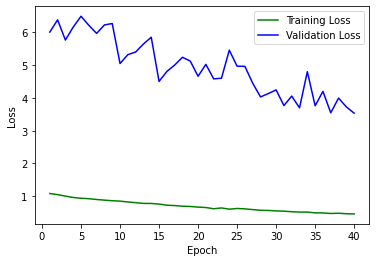

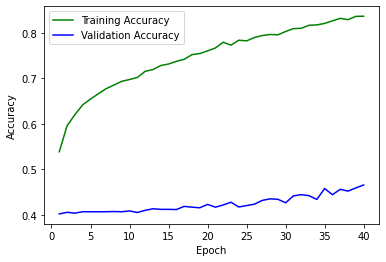

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,371,3221,5,0,3
1,0,3586,4,0,10
2,2,2303,1070,57,168
3,0,938,325,852,1485
4,0,14,1,2,3583


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,28,372,0,0,0
1,0,400,0,0,0
2,0,286,99,0,15
3,0,117,20,88,175
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,60,815,3,3,1
1,1,586,2,1,4
2,0,189,18,8,19
3,2,79,7,64,82
4,0,6,0,5,340


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,3,95,0,0,0
1,0,66,0,0,0
2,0,23,0,1,2
3,0,11,0,7,8
4,0,0,0,0,39


filenames: 255
labels: 255
predictions: 255
predictions file: output/ezEXhPbCNcpGmf8NrFXror/ezEXhPbCNcpGmf8NrFXror_predict_c2_h2_test.csv
1: 145
4: 55
Finished generating predictions to output/ezEXhPbCNcpGmf8NrFXror/ezEXhPbCNcpGmf8NrFXror_predict_c2_h2_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [73]:
model = get_model(2048, 256, 0.5).to(device)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output/4vXgWCcib9nMxiGRN55F35
Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:33.339679 loss: 1.0970 accuracy: 0.5286
Num samples 2295
val 0:00:04.742837 loss: 4.6801 accuracy: 0.3987
Elapsed time: 0:00:38.085509

Epoch 1/39
----------
Num samples 18000
train 0:00:33.775088 loss: 1.0506 accuracy: 0.5921
Num samples 2295
val 0:00:04.666541 loss: 5.4705 accuracy: 0.4031
Elapsed time: 0:00:38.444368

Epoch 2/39
----------
Num samples 18000
train 0:00:33.476674 loss: 1.0254 accuracy: 0.6081
Num samples 2295
val 0:00:04.735375 loss: 4.4830 accuracy: 0.4035
Elapsed time: 0:00:38.215221

Epoch 3/39
----------
Num samples 18000
train 0:00:33.487707 loss: 0.9855 accuracy: 0.6237
Num samples 2295
val 0:00:04.655708 loss: 4.4362 accuracy: 0.4052
Elapsed time: 0:00:38.146545

Epoch 4/39
----------
Num samples 18000
train 0:00:33.405378 loss: 0.9492 accuracy: 0.6353
Num samples 22

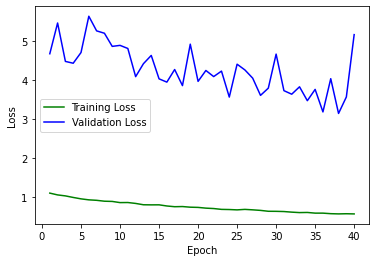

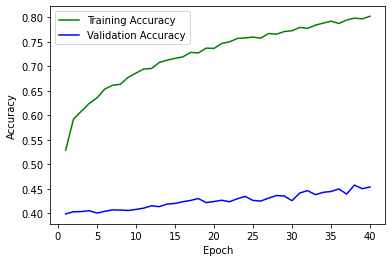

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,226,3364,9,0,1
1,0,3591,3,0,6
2,2,2384,969,77,168
3,0,1190,224,1005,1181
4,0,20,2,17,3561


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,9,391,0,0,0
1,0,400,0,0,0
2,0,305,80,0,15
3,0,149,16,116,119
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,25,849,5,3,0
1,1,589,2,0,2
2,0,196,14,10,14
3,1,94,2,87,50
4,0,5,1,10,335


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,2,96,0,0,0
1,0,66,0,0,0
2,0,24,0,1,1
3,0,12,0,7,7
4,0,0,0,0,39


filenames: 255
labels: 255
predictions: 255
predictions file: output/4vXgWCcib9nMxiGRN55F35/4vXgWCcib9nMxiGRN55F35_predict_c2_h3_test.csv
1: 145
4: 55
Finished generating predictions to output/4vXgWCcib9nMxiGRN55F35/4vXgWCcib9nMxiGRN55F35_predict_c2_h3_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [74]:
model = get_model(512, 64, 0.5).to(device)
run_trial("h3", model)

#### H4: Best from above, dropout 0.25

* DNN Structure: 
* Dropout: 0.25
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output/3ULo4bMZSnTVUFfXR72Udq
Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:35.806635 loss: 1.0682 accuracy: 0.5461
Num samples 2295
val 0:00:05.011200 loss: 5.2624 accuracy: 0.4013
Elapsed time: 0:00:40.820859

Epoch 1/39
----------
Num samples 18000
train 0:00:35.671373 loss: 1.0229 accuracy: 0.6061
Num samples 2295
val 0:00:04.956865 loss: 5.8106 accuracy: 0.4039
Elapsed time: 0:00:40.631159

Epoch 2/39
----------
Num samples 18000
train 0:00:35.742079 loss: 0.9737 accuracy: 0.6331
Num samples 2295
val 0:00:04.984891 loss: 6.3719 accuracy: 0.4013
Elapsed time: 0:00:40.727652

Epoch 3/39
----------
Num samples 18000
train 0:00:36.222495 loss: 0.9544 accuracy: 0.6505
Num samples 2295
val 0:00:05.227338 loss: 6.3070 accuracy: 0.4022
Elapsed time: 0:00:41.450774

Epoch 4/39
----------
Num samples 18000
train 0:00:36.893646 loss: 0.9318 accuracy: 0.6624
Num samples 22

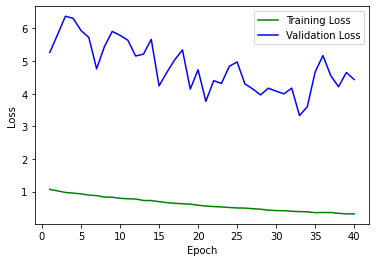

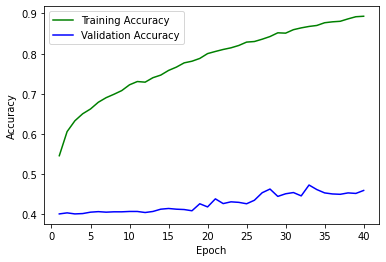

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,376,3215,7,2,0
1,0,3586,2,7,5
2,1,2231,1121,98,149
3,0,808,217,1226,1349
4,0,7,0,8,3585


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,19,381,0,0,0
1,0,400,0,0,0
2,0,277,107,1,15
3,0,102,16,143,139
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,54,817,4,7,0
1,2,582,4,4,2
2,0,182,21,17,14
3,1,70,3,89,71
4,0,3,0,8,340


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,2,96,0,0,0
1,0,66,0,0,0
2,0,23,0,2,1
3,0,10,0,8,8
4,0,0,0,1,38


filenames: 255
labels: 255
predictions: 255
predictions file: output/3ULo4bMZSnTVUFfXR72Udq/3ULo4bMZSnTVUFfXR72Udq_predict_c2_h4_test.csv
1: 145
4: 55
Finished generating predictions to output/3ULo4bMZSnTVUFfXR72Udq/3ULo4bMZSnTVUFfXR72Udq_predict_c2_h4_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [15]:
model = get_model(2048, 256, 0.25).to(device)
run_trial("h4", model)

#### H5: Best from above, dropout 0.1

* DNN Structure: 
* Dropout: 0.1
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output/XS4qxaR2qarkNoTPVPMSQo
Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:33.488227 loss: 1.0671 accuracy: 0.5473
Num samples 2295
val 0:00:04.756618 loss: 5.1144 accuracy: 0.4022
Elapsed time: 0:00:38.247844

Epoch 1/39
----------
Num samples 18000
train 0:00:33.562693 loss: 1.0134 accuracy: 0.6092
Num samples 2295
val 0:00:04.701521 loss: 5.5084 accuracy: 0.4026
Elapsed time: 0:00:38.267221

Epoch 2/39
----------
Num samples 18000
train 0:00:33.673519 loss: 0.9617 accuracy: 0.6426
Num samples 2295
val 0:00:04.787042 loss: 6.3450 accuracy: 0.4022
Elapsed time: 0:00:38.461403

Epoch 3/39
----------
Num samples 18000
train 0:00:33.725023 loss: 0.9493 accuracy: 0.6578
Num samples 2295
val 0:00:04.786503 loss: 6.3734 accuracy: 0.4061
Elapsed time: 0:00:38.513617

Epoch 4/39
----------
Num samples 18000
train 0:00:33.916614 loss: 0.9017 accuracy: 0.6762
Num samples 22

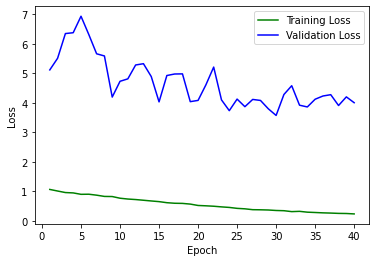

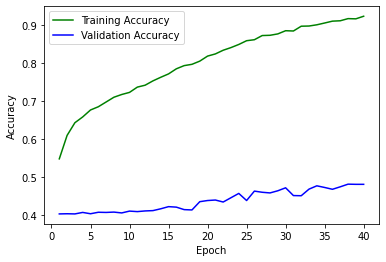

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,541,3056,1,2,0
1,0,3589,4,5,2
2,4,2057,1374,46,119
3,0,795,271,1476,1058
4,0,2,1,7,3590


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,44,356,0,0,0
1,0,400,0,0,0
2,0,243,142,1,14
3,0,101,18,177,104
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,76,796,2,8,0
1,7,579,4,3,1
2,0,187,24,12,11
3,1,72,9,90,62
4,0,5,1,11,334


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,3,94,0,1,0
1,0,66,0,0,0
2,0,24,1,0,1
3,0,10,0,10,6
4,0,0,0,1,38


filenames: 255
labels: 255
predictions: 255
predictions file: output/XS4qxaR2qarkNoTPVPMSQo/XS4qxaR2qarkNoTPVPMSQo_predict_c2_h5_test.csv
0: 1
1: 144
4: 55
Finished generating predictions to output/XS4qxaR2qarkNoTPVPMSQo/XS4qxaR2qarkNoTPVPMSQo_predict_c2_h5_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [16]:
model = get_model(2048, 256, 0.1).to(device)
run_trial("h5", model)

#### H6: Best from above, skewed class weights

* DNN Structure: 
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


Output generated to: output/QghUfUCsEknSX5sbNFki3B
Reading annotations...
Using class weights: tensor([1., 1., 2., 2., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 18000
train 0:00:33.588554 loss: 1.0903 accuracy: 0.5374
Num samples 2295
val 0:00:04.779201 loss: 6.2389 accuracy: 0.4009
Elapsed time: 0:00:38.371027

Epoch 1/39
----------
Num samples 18000
train 0:00:34.070862 loss: 1.0485 accuracy: 0.5917
Num samples 2295
val 0:00:04.805629 loss: 7.3498 accuracy: 0.4013
Elapsed time: 0:00:38.878514

Epoch 2/39
----------
Num samples 18000
train 0:00:35.026754 loss: 1.0520 accuracy: 0.6125
Num samples 2295
val 0:00:04.734747 loss: 6.7133 accuracy: 0.4039
Elapsed time: 0:00:39.764641

Epoch 3/39
----------
Num samples 18000
train 0:00:34.222662 loss: 0.9655 accuracy: 0.6398
Num samples 2295
val 0:00:04.815948 loss: 7.8123 accuracy: 0.4052
Elapsed time: 0:00:39.041662

Epoch 4/39
----------
Num samples 18000
train 0:00:33.891614 loss: 0.9529 accuracy: 0.6569
Num samples 2295
val

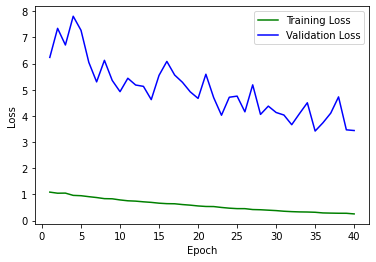

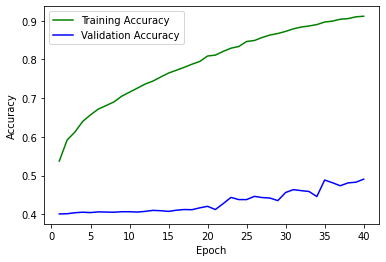

Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,569,3008,21,2,0
1,0,3576,17,5,2
2,1,1653,1781,44,121
3,0,677,362,1273,1288
4,0,7,3,6,3584


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,46,354,0,0,0
1,0,400,0,0,0
2,0,185,200,0,15
3,0,84,29,149,138
4,0,0,0,0,400


filenames: 2000
labels: 2000
predictions: 2000
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,85,774,18,4,1
1,7,572,10,5,0
2,1,165,44,11,13
3,1,64,17,87,65
4,0,2,2,9,338


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,4,94,0,0,0
1,0,66,0,0,0
2,0,23,2,0,1
3,0,6,0,10,10
4,0,0,0,1,38


filenames: 255
labels: 255
predictions: 255
predictions file: output/QghUfUCsEknSX5sbNFki3B/QghUfUCsEknSX5sbNFki3B_predict_c2_h6_test.csv
0: 1
1: 144
4: 55
Finished generating predictions to output/QghUfUCsEknSX5sbNFki3B/QghUfUCsEknSX5sbNFki3B_predict_c2_h6_test.csv


tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [18]:
model = get_model(2048, 256, 0.1).to(device)
run_trial("h6", model, class_weights=torch.tensor([1., 1., 2., 2., 1.]).to(device))

#### H7: Best from above, batch normalization

* DNN Structure: 
* Dropout: 0.5
* Class weights: 
* Batch normalization: yes


In [ ]:
model = get_model(n1, n2, 0.5, batch_normalization=True).to(device)
run_trial("h7", model)

#### Summary: Best hyperparameters

In [ ]:
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.1


## Train with all C2 data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d).to(device)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=40)
predictions_file = "predict_c2_{}.csv".format(shortuuid.uuid())
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)

In [ ]:
torch.set_printoptions(profile="full")
print(y_hat_test)
torch.set_printoptions(profile="default")

### Save model

In [ ]:
torch.save(model.state_dict(), 'cnn_pytorch_c2.pt')